In [22]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.affinity import scale, translate

from PIL import Image

In [18]:
def rgb_to_hex(rgb):
    """
    Convert RGB color representation to hexadecimal format.
    
    Args:
    - rgb (list): List containing RGB color values [R, G, B].
    
    Returns:
    - str: Hexadecimal representation of the RGB color.
    """
    return '#{:02x}{:02x}{:02x}'.format(*rgb)


# Define a function to scale a single geometry object
def scale_geometry(geom, scaling_factor):
    return scale(geom, xfact=scaling_factor, yfact=scaling_factor, zfact=1, origin=(0, 0))



In [35]:
to_drop = ["id", "objectType", "classification"]
labels_df = gpd.read_file('./data/GeoJson/H21-066.4_HE332_033_Scan1.qptiff - resolution #1.geojson')
labels_df["label"] = labels_df["classification"].apply(lambda x: x["name"])
labels_df["color"] = labels_df["classification"].apply(lambda x: rgb_to_hex(x["color"]))
labels_df = labels_df.drop(columns=to_drop)
# Scale the coordinates
labels_df['geometry'] = labels_df['geometry'].apply(lambda row: scale_geometry(row, (1/4)))

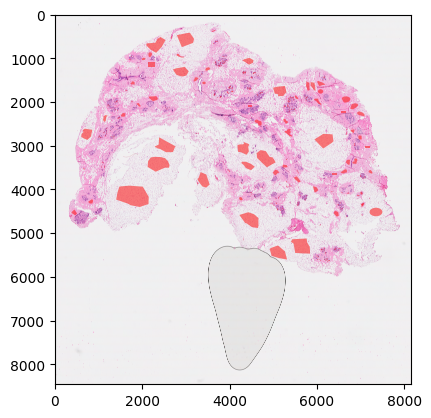

In [20]:
# Load the TIFF image
image_path = './data/66-4/H21-066.4_HE332_033/processed_8/H21-066.4_HE332_033_Scan1.tif'
pil_image = Image.open(image_path)

labels_df.plot(ax=plt.gca(), color='red', alpha=0.5, aspect=1)
plt.imshow(pil_image)
plt.show()

# Training Pipeline

## Preprocessing

### Normalize training images

Can be done later

### Optical Density?
Can be done later

### Bounding boxes of annotations

In [41]:
# Open the image
import cv2
image = cv2.imread("./data/66-4/H21-066.4_HE332_033/processed_4/H21-066.4_HE332_033_Scan1.tif")

316


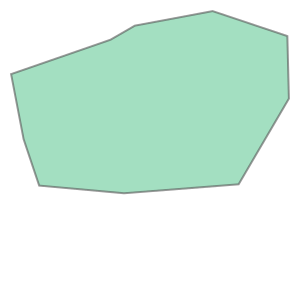

In [42]:
def get_largest_polygon(gdf):
    largest_polygon = None
    largest_area = -1
    i = 0

    for index, row in gdf.iterrows():
        polygon = row['geometry']
        area = polygon.area
        if area > largest_area:
            largest_area = area
            largest_polygon = polygon
            i = index
    
    print(i)

    return largest_polygon

get_largest_polygon(labels_df)

In [43]:

def extract_label(idx):
    polygon_gdf = labels_df["geometry"][idx]
    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = np.floor(polygon_gdf.bounds).astype("int64")
    crop = image[min_y:max_y, min_x:max_x]

    translate_x = ((max_x-min_x) - polygon_gdf.bounds[0] - polygon_gdf.bounds[2]) / 2
    translate_y = ((max_y-min_y) - polygon_gdf.bounds[1] - polygon_gdf.bounds[3]) / 2
    translated_polygon = translate(polygon_gdf, xoff=translate_x, yoff=translate_y)

    contour = np.array([[int(x), int(y)] for x, y in translated_polygon.exterior.coords])

    mask = np.zeros_like(crop)*255
    cv2.fillPoly(mask, pts=[contour], color=(255,255,255))
    masked_img = cv2.bitwise_and(crop, mask)


    plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
    #plt.plot(*translated_polygon.exterior.xy, color='red')
    
    plt.axis('off')  # Turn off axis
    plt.show()
    cv2.imwrite("test.png", masked_img)
    return True


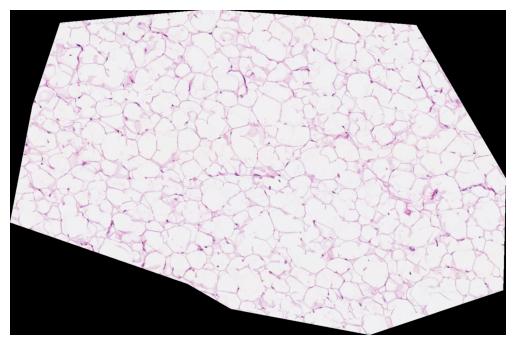

True

In [44]:
extract_label(316)

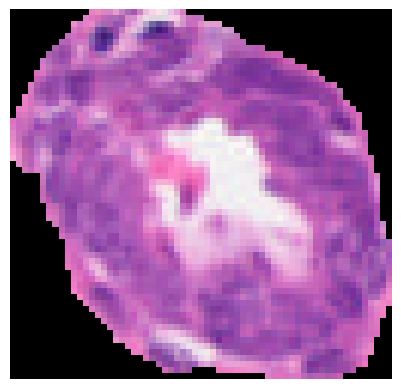

True

In [48]:
extract_label(37)

### Save each region as a separated image file

### Matrix to keep track of annotations tissue type (label)

## Training

### Create a 9000x9000x3 grid

### Fill the grid with bounding boxes until >65% of area is filled 

- Keep track o equal n pixel per class.
- Randomly augment bounding boxes by using rotation, scaling, hue


### Crop 9000x9000 images into 500x500 (324 image per 9000 tile)

In CODA they use 20 images of 9Kx9K for training, 5 of 9Kx9k for validation and 1 unlabelled for testing.

This results in:
- Train: 6480
- Validation: 1620
- Test 324

## Evaluation 

They looked for >90% precision and recall accuracies for every tissue type